<a href="https://colab.research.google.com/github/parjanya-rajput/-FR-202201115-Ai-Ascension-/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WELCOM TO THE FACE RECOGNITION SYSTEM BUILT USING SIAMESE NETWORK

In [ ]:
!pip install opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Importing dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import uuid
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import PIL
import io
import html
import time
#Tensorflow dependencies
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [47]:
#Setting Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [48]:
#Make Folders
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

Labbelled faces in **WILD DATASET**
URL: http://vis-www.cs.umass.edu/lfw/

In [49]:
#Uncompressing the Tar GZ file lfw
!tar -xf lfw.tgz

In [50]:
#Moving all the wild face data to negative for training the model
for directory in os.listdir('lfw'):
  for f in os.listdir(os.path.join('lfw', directory)):
    EX_PATH = os.path.join('lfw', directory, f)
    NEW_PATH = os.path.join(NEG_PATH, f)
    os.replace(EX_PATH, NEW_PATH)

In [51]:
#Code for removing all the lfw set files and saving space
for dir in os.listdir('lfw'):
  path = os.path.join('lfw', dir)
  os.rmdir(path)

Helper Functions for capturing Image in Collab

In [52]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

Haar Cascade Classifier

In [53]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [54]:
def take_photo(filename='{}.jpg'.format(uuid.uuid1()), quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve)
        
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
      
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      # img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      img = img[y:y+h, x:x+w]
      print(x,y,w,h)
  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
253 194 177 177
Saved to data/anchor/0c11a322-beb0-11ed-809b-0242ac1c000c.jpg


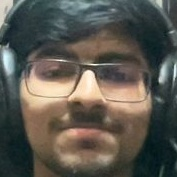

In [55]:
try:
  #Just change ANC_PATH to  POS_PATH for stroing positive image
  filename = take_photo(os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1())))
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [56]:
# Change jpg to png for differnet type of image 
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [57]:
dir_test = anchor.as_numpy_iterator()

In [58]:
dir_test.next()

b'data/anchor/d03ac726-bde6-11ed-ad76-46baee1e3e63.jpg'

Preprocessing Function

In [59]:
def preprocess(file_path):

  #Reading the image from the filepath
  byte_img = tf.io.read_file(file_path)

  #Loading the image from filepath
  img = tf.io.decode_jpeg(byte_img)

  #Resizing the image
  img = tf.image.resize(img, (105,105))

  #Scaling the image. to fit in 0 to 1
  img = img / 255.0

  return img

In [62]:
# img = preprocess('data/anchor/e6bfa924-bdd9-11ed-aec5-0242ac1c000c.jpg')

In [63]:
# img.numpy().max()

In [64]:
# plt.imshow(img)

Now I am trying to create a labelled dataset

In [65]:
#What it will be resulting
# (anchor,positive) => 1,1,1,1,1
# (anchor,negative) => 0,0,0,0,0

In [66]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [67]:
samples = data.as_numpy_iterator()

In [68]:
exp = samples.next()

In [69]:
exp

(b'data/anchor/d6722670-bde6-11ed-ad76-46baee1e3e63.jpg',
 b'data/positive/b665e3a8-bde6-11ed-ad76-46baee1e3e63.jpg',
 1.0)

Training and Testing the Partition

In [70]:
def preprocess_twin(input_img, validation_img, label):
  return(preprocess(input_img), preprocess(validation_img), label)

In [71]:
res = preprocess_twin(*exp)

In [72]:
res[2]

1.0

Building DATALOADER PIPELINE

In [73]:
data = data.map(preprocess_twin)
data = data.cache()
data.shuffle(buffer_size=1024)

<ShuffleDataset element_spec=(TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [74]:
samples = data.as_numpy_iterator()

In [75]:
samp = samples.next()

In [76]:
#Train Partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [77]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 105, 105, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [78]:
#Testing Data
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

**EMBEDDING LAYER**

In [80]:
inp = Input(shape=(105,105,3), name = 'input_img')

In [81]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [82]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d_8')>

In [83]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [84]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d_6')>

In [85]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [86]:
c2

<KerasTensor: shape=(None, 42, 42, 128) dtype=float32 (created by layer 'conv2d_9')>

In [87]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_7')>

In [88]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [89]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_8')>

In [90]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

Flatten results c4=> 6*6*256 = 9216

In [91]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten_2')>

In [92]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_4')>

In [93]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [94]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 128)       26

In [95]:
def make_embedding():
  #Input image 105x105
  inp = Input(shape=(105,105,3), name='input_image')

  #Applying Convulution layer
  c1 = Conv2D(64, (10,10), activation='relu')(inp)

  # Maxpooling the c1 layer
  m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

  #Second Block for neural network
  c2 = Conv2D(128, (7,7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

  #Third Block for neural network
  c3 = Conv2D(128, (4,4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

  #Final convolution then flatten and densing the layer i.e embedding layer
  c4 = Conv2D(256, (4,4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)
  


  return Model(inputs=[inp], outputs=[d1], name='embedding')

In [96]:
embedding = make_embedding()

In [97]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 21, 21, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 128)       26

#Building DISTANCE LAYER
This is the defining characteristic in Siamese Neural Network used for Keras layering

In [98]:
class L1Dist(Layer):

  #Inheritance
  def __init__(self,**kwargs):
    super().__init__()

    #Turning the feature vector(d1) into one single output
    def call(self, input_embedding, validation_embedding):
      return tf.math.abs(input_embedding - validation_embedding)

In [99]:
siamese_layer = L1Dist()

# SIAMESE NEURAL NETWORK

In [100]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [101]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [102]:
distances = siamese_layer(inp_embedding, val_embedding)

In [103]:
classifier = Dense(1, activation='sigmoid')(distances)

In [104]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [105]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [106]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [107]:
def make_siamese_model():

  #Handling the input images
  input_image = Input(name='input_img', shape=(105,105,3))
  validation_image = Input(name='validation_img', shape=(105,105,3))

  #Siamese Distance components
  siamese_layer = L1Dist()
  siamese_layer._name = 'Distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  #Classification 
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [108]:
siamese_model = make_siamese_model()

In [109]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

**Loss and Optimiser Setup**

In [110]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [111]:
opt = tf.keras.optimizers.Adam(1e-4)

**Checkpoint Components**

In [ ]:
cp = os.path.join('training_checkpoints')
os.makedirs(cp)
checkpoint_dir = './training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

**Train Step Function**

In [116]:
@tf.function
def train_step(batch):

  with tf.GradientTape() as tape:

    #Fetch Anchor Images
    X = batch[:2]
    #Fetch Label
    y = batch[2]

    #predict 
    yhat = siamese_model(X, training=True)

    #Calc Loss
    loss = binary_cross_loss(y, yhat)
  print(loss)

  #calculate gradients
  grad = tape.gradient(loss, siamese_model.trainable_variables)

  #Calculate updated weights and apply to siamese model
  opt.apply_gradients(zip(grad, siamese_model.trainable_variables))  
  return loss

**Training Loop**

In [117]:
def train(data, EPOCHS):
  #Loop through all epochs
  for epoch in range(1, EPOCHS+1):
    print(('\n EPOCH {}/{}'.format(epoch, EPOCHS)))
    progbar = tf.keras.utils.Progbar(len(data))

    #Looping through each batch
    for idx, batch in enumerate(data):
      #Running Train Step 
      train_step(batch)
      progbar.update(idx+1)

      #Save the checkpoints
      if epoch % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)


**Train the Model**

In [118]:
EPOCHS = 50

In [119]:
train(train_data, EPOCHS)


 EPOCH 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
14/14 [==============================] - 15s 137ms/step

 EPOCH 2/50
14/14 [==============================] - 2s 118ms/step

 EPOCH 3/50
14/14 [==============================] - 1s 110ms/step

 EPOCH 4/50
14/14 [==============================] - 1s 111ms/step

 EPOCH 5/50
14/14 [==============================] - 1s 110ms/step

 EPOCH 6/50
14/14 [==============================] - 1s 111ms/step

 EPOCH 7/50
14/14 [==============================] - 1s 111ms/step

 EPOCH 8/50
14/14 [==============================] - 1s 111ms/step

 EPOCH 9/50
14/14 [==============================] - 1s 110ms/step

 EPOCH 10/50
14/14 [==============================] - 8s 628ms/step

 EPOCH 11/50
14/14 [==============================] - 1s 108ms/step

 EPOCH 12/50
14/14 [==============================] - 1s 109ms/step

 EPOCH 13/50
14/14 [=====